In [2]:
import tensorflow as tf
import numpy as np
import glob
import random
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg

In [3]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU') #本地需要这样操作
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu ,True)

In [4]:
x_path=glob.glob('./dataset/cloth/*/*')


In [5]:

random.shuffle(x_path)

In [6]:
x_path[0].split('\\')[-2]

'blue_jeans'

In [7]:
y_label=[p.split('\\')[-2] for p in x_path]

label_names=set(y_label)
y_label

['blue_jeans',
 'black_shoes',
 'red_shirt',
 'black_shoes',
 'red_dress',
 'black_jeans',
 'blue_shirt',
 'red_shirt',
 'black_jeans',
 'black_jeans',
 'red_shirt',
 'blue_shirt',
 'blue_shirt',
 'red_dress',
 'blue_jeans',
 'red_dress',
 'black_jeans',
 'black_jeans',
 'red_shirt',
 'red_shirt',
 'black_jeans',
 'black_jeans',
 'blue_jeans',
 'blue_jeans',
 'red_dress',
 'black_jeans',
 'black_shoes',
 'red_dress',
 'blue_shirt',
 'red_dress',
 'black_shoes',
 'blue_jeans',
 'black_shoes',
 'black_shoes',
 'blue_dress',
 'blue_shirt',
 'blue_jeans',
 'black_jeans',
 'black_jeans',
 'blue_dress',
 'blue_shirt',
 'blue_dress',
 'red_shirt',
 'blue_dress',
 'blue_jeans',
 'blue_shirt',
 'black_jeans',
 'blue_jeans',
 'black_shoes',
 'blue_jeans',
 'blue_dress',
 'black_jeans',
 'black_shoes',
 'red_shirt',
 'black_shoes',
 'red_dress',
 'black_shoes',
 'blue_jeans',
 'blue_dress',
 'red_dress',
 'blue_shirt',
 'red_shirt',
 'red_shirt',
 'black_jeans',
 'blue_shirt',
 'blue_shirt',
 'bl

In [8]:
color_label_names = set(name.split('_')[0] for name in label_names)
color_label_names

{'black', 'blue', 'red'}

In [9]:
item_label_names = set(name.split('_')[1] for name in label_names)
item_label_names


{'dress', 'jeans', 'shirt', 'shoes'}

In [10]:
color_label_to_index = dict((name, index) for index,name in enumerate(color_label_names))
color_label_to_index

{'blue': 0, 'red': 1, 'black': 2}

In [11]:
item_label_to_index = dict((name, index) for index,name in enumerate(item_label_names))
item_label_to_index

{'shirt': 0, 'jeans': 1, 'shoes': 2, 'dress': 3}

In [12]:
y_color = [color_label_to_index[label.split('_')[0]] for label in y_label]
y_item= [item_label_to_index[label.split('_')[1]] for label in y_label]


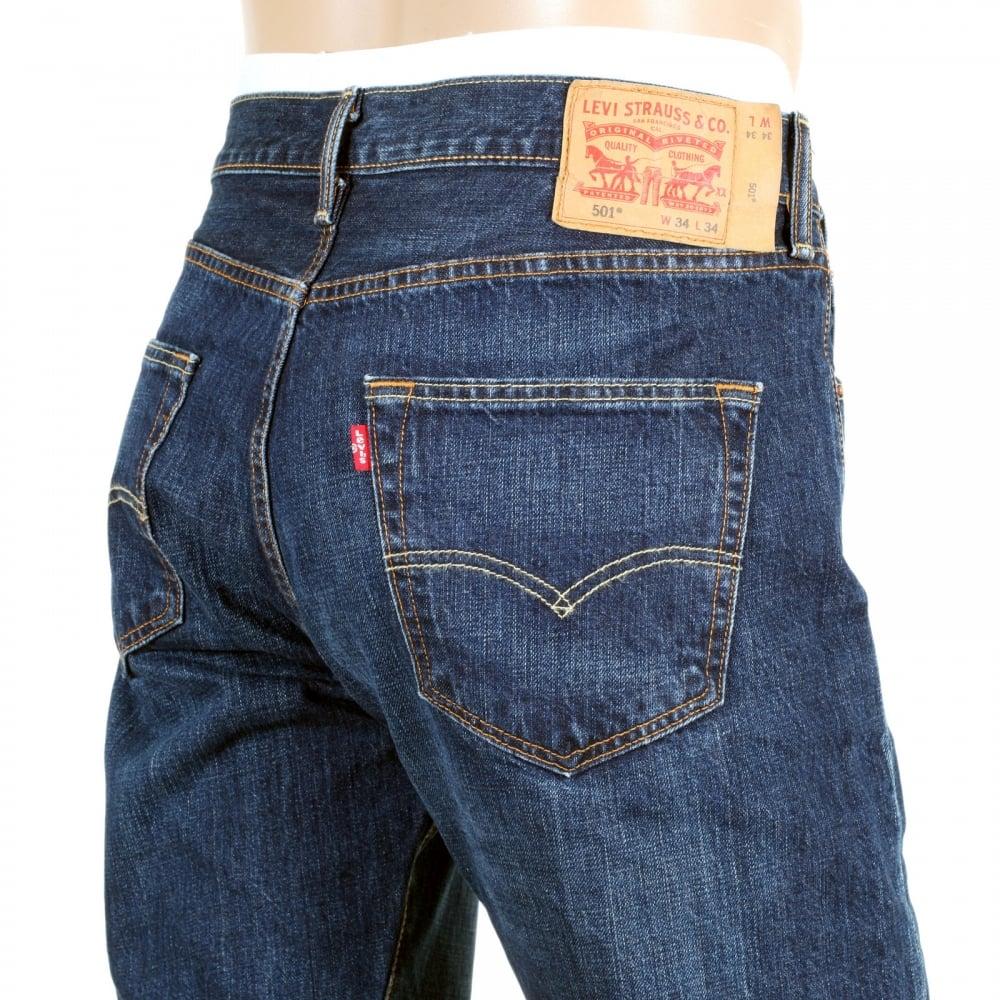

blue_jeans


In [13]:
import IPython.display as display
display.display(display.Image(x_path[0] ,width=20, height=20))
print(y_label[0])

In [14]:
def load_preprosess_image(img_path):
    img_raw=tf.io.read_file(img_path)   
    img_tensor=tf.image.decode_jpeg(img_raw,channels=3)
    img_tensor=tf.image.resize(img_tensor,[224,224])
    img_tensor=tf.cast(img_tensor,tf.float32)
    img_tensor=img_tensor/224
    #img_tensor = 2*img_tensor-1
    return img_tensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0, 'blue_jeans')

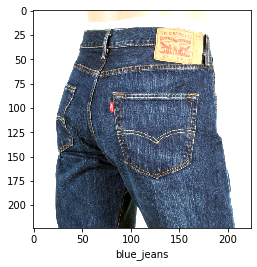

In [15]:
plt.imshow(load_preprosess_image(x_path[0]))
plt.xlabel(y_label[0])

In [16]:
path_dataset=tf.data.Dataset.from_tensor_slices(x_path)
x_dataset=path_dataset.map(load_preprosess_image)
y_dataset=tf.data.Dataset.from_tensor_slices((y_color, y_item))


In [17]:
dataset=tf.data.Dataset.zip((x_dataset,y_dataset))

In [18]:
dataset

<ZipDataset shapes: ((224, 224, 3), ((), ())), types: (tf.float32, (tf.int32, tf.int32))>

In [23]:
data_count = len(x_path)
test_count = int(data_count*0.2)
train_count = data_count - test_count


In [24]:
dataset_train = dataset.skip(test_count)

dataset_test = dataset.take(test_count)

In [25]:
BATCH_SIZE = 4


In [26]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
dataset_train=dataset_train.shuffle(train_count).repeat().batch(BATCH_SIZE).prefetch(AUTOTUNE)
dataset_test=dataset_test.repeat().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)




## 建立模型

In [22]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), 
                                               include_top=False,
                                               weights='imagenet')

In [23]:
mobile_net.trianable = False

In [24]:
inputs = tf.keras.Input(shape=(224, 224, 3))

In [25]:
x = mobile_net(inputs)

In [26]:
x.get_shape()

TensorShape([None, 7, 7, 1280])

In [27]:
x = tf.keras.layers.GlobalAveragePooling2D()(x)

In [28]:
x.get_shape()

TensorShape([None, 1280])

In [29]:
x1 = tf.keras.layers.Dense(1024, activation='relu')(x)
out_color = tf.keras.layers.Dense(len(color_label_names), 
                                  activation='softmax',
                                  name='out_color')(x1)

In [30]:
x2 = tf.keras.layers.Dense(1024, activation='relu')(x)
out_item = tf.keras.layers.Dense(len(item_label_names), 
                                 activation='softmax',
                                 name='out_item')(x2)

In [31]:
model = tf.keras.Model(inputs=inputs,
                       outputs=[out_color, out_item])

In [32]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
mobilenetv2_1.00_224 (Model)    (None, 7, 7, 1280)   2257984     input_2[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 1280)         0           mobilenetv2_1.00_224[1][0]       
__________________________________________________________________________________________________
dense (Dense)                   (None, 1024)         1311744     global_average_pooling2d[0][0]   
______________________________________________________________________________________________

In [33]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss={'out_color':'sparse_categorical_crossentropy',
                    'out_item':'sparse_categorical_crossentropy'},
              metrics=['acc']
)


In [34]:
dataset_train

<PrefetchDataset shapes: ((None, 224, 224, 3), ((None,), (None,))), types: (tf.float32, (tf.int32, tf.int32))>

In [35]:
dataset_test

<PrefetchDataset shapes: ((None, 224, 224, 3), ((None,), (None,))), types: (tf.float32, (tf.int32, tf.int32))>

In [36]:
model.fit(dataset_train,
          epochs=1,
          steps_per_epoch=train_count//BATCH_SIZE,
          validation_data=dataset_test,
          validation_steps=test_count//BATCH_SIZE,
)

Train for 505 steps, validate for 126 steps
505/505 [==============================] - 62s 123ms/step - loss: 0.6754 - out_color_loss: 0.3470 - out_item_loss: 0.3284 - out_color_acc: 0.8639 - out_item_acc: 0.8812 - val_loss: 0.1609 - val_out_color_loss: 0.0572 - val_out_item_loss: 0.1037 - val_out_color_acc: 0.9782 - val_out_item_acc: 0.9563

In [ ]:

model.evaluate(dataset_test,verbose=0)

In [37]:
#自己测试
my_image = load_preprosess_image(x_path[0])

In [38]:
my_image.shape

TensorShape([224, 224, 3])

In [39]:
my_image = tf.expand_dims(my_image, 0)

In [ ]:
my_image.shape

In [40]:
pred = model.predict(my_image)

In [41]:
np.argmax(pred[0])

2

In [42]:
np.argmax(pred[1])

3

In [43]:
print(x_path[0])
print(color_label_to_index)
print(item_label_to_index)

./dataset/cloth\red_shirt\00000275.jpg
{'blue': 0, 'black': 1, 'red': 2}
{'dress': 0, 'shoes': 1, 'jeans': 2, 'shirt': 3}
